In [1]:
from MALBuddy import MALBuddy
import pandas as pd
import os
import re
import numpy as np

client_info_filepath = "client_info.json"
token_filepath = "token.json"

In [2]:
buddy = MALBuddy(client_info_filepath, token_filepath)


In [3]:
def genre_from_dict_list(genre_list):
    genres = []
    for entry in genre_list:
        genres.append(entry['name'])
    return genres

In [4]:
user = 'chocopieeater'
anime_list = buddy.get_anime_list(user)
anime_list.head()

id                    title  \
0  41457                       86   
1  22199           Akame ga Kill!   
2  41433            Akudama Drive   
3  22729             Aldnoah.Zero   
4  27655  Aldnoah.Zero 2nd Season   

                                        main_picture     status  score  \
0  {'medium': 'https://api-cdn.myanimelist.net/im...    dropped      0   
1  {'medium': 'https://api-cdn.myanimelist.net/im...  completed      8   
2  {'medium': 'https://api-cdn.myanimelist.net/im...    dropped      0   
3  {'medium': 'https://api-cdn.myanimelist.net/im...  completed      6   
4  {'medium': 'https://api-cdn.myanimelist.net/im...    dropped      0   

   num_episodes_watched  is_rewatching                 updated_at finish_date  \
0                     0          False  2021-05-02T00:36:51+00:00         NaN   
1                    24          False  2019-02-26T07:05:44+00:00         NaN   
2                     7          False  2020-12-28T21:14:38+00:00         NaN   
3                    12          False  2018-08-07T02:05:12+00:00         NaN   
4                    11          False  2018-08-07T01:31:22+00:00         NaN   

  start_date  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [5]:
id_title = zip(anime_list['id'].to_numpy(),anime_list['title'].to_numpy())
for id_, title in id_title:
    buddy.generate_and_write_ratings(id_, title, num_pages=5)
    print()

Successfully loaded pages: : 1, 

KeyboardInterrupt: 

In [ ]:
buddy.load_ratings('86')

In [ ]:
from datetime import datetime
start = datetime.now()
try:
    id_title = zip(anime_list['id'].to_numpy(),anime_list['title'].to_numpy())
    for id_, title in id_title:
        buddy.generate_and_write_users(id_, title, num_pages=5)
except:
    print("Something Went Wrong")
    
elapsed = datetime.now() - start
print(f"Total time taken: {elapsed}")


In [305]:
l = buddy.get_anime_list('chocopieeater')[['id','score']]
l[l['score'] != 0]

id  score
1    22199      8
3    22729      6
5     6547      8
6    24833      8
8     9919      7
..     ...    ...
228  37779      9
229  39617      4
230  32615      8
232  37055      8
233  35507      8

[132 rows x 2 columns]

In [5]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['user_id', 'movie_id']].values
    values = ratings_df['score'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [7]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
    axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [8]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    """
    Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
    Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
    """
    predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [9]:
# @title CFModel helper class (run this cell)
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

          # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
        return results

In [10]:
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [11]:
#@title Solution
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
    model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    print(A_train.shape)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    print(train_loss)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "user_id": U,
      "movie_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [12]:
# loads users from webscraped jsons
#buddy.make_users_to_load()

In [120]:
unloaded_users

338     stewpidIDioT
339    misbehavement
340       Mistra_exe
342             Jrox
343          liewwwn
           ...      
742     Little_Kaiju
743       9_liebe_xd
744      eat_magnets
739           mrtrob
741        Zoltar565
Length: 399, dtype: object

In [121]:
#generate new user animelists
from datetime import datetime
start = datetime.now()
user_df = pd.DataFrame()
users_to_load = buddy.get_unloaded_users()
existing_users = pd.DataFrame(buddy.read_json('user_ratings.json'))
unloaded_users = users_to_load[pd.Series(users_to_load).apply(lambda x: x not in existing_users['user'].unique())]
cur_id = 0

num_to_load = 100

print(f"Generating {num_to_load} new anime lists")
for x in range(num_to_load):
    try:
        user = unloaded_users[x]
        print(f"Generating anime list for {user}")
        user_mal = buddy.get_anime_list(user)
        if type(user_mal) != str:
            user_mal = user_mal[['id','score']] # retrieve anime id and score
            user_mal = user_mal[user_mal['score'] != 0] #drop unrated shows
            user_mal['user'] = user 
            if(len(user_mal) > 0):
                user_df = pd.concat([user_df, user_mal])
                cur_id += 1
            else:
                print(f"removing {user}")
                buddy.remove_from_user_list(user)
        else:
            print(f"removing {user}")
            buddy.remove_from_user_list(user)
    except:
        print(f"Error loading {user}")
        print(f"removing {user}")
        buddy.remove_from_user_list(user)

elapsed = datetime.now() - start
print(elapsed)

Generating 100 new anime lists
Generating anime list for Tirantus
Generating anime list for SiNKarnage
Generating anime list for DEIN2001
Generating anime list for GayCheerios
Generating anime list for Bay10E
Generating anime list for yazeedovich
Generating anime list for Laura610
Generating anime list for levisbaenr1
Generating anime list for JustMe2306
Generating anime list for Palaby
Generating anime list for AxE_Ace
Error requesting anime list. Aborting...
Error loading AxE_Ace
removing AxE_Ace
Generating anime list for Xono
Generating anime list for Jeppe_Boddum
Generating anime list for jeshinia
Generating anime list for hergerhbyenyet
Generating anime list for Labryx
Generating anime list for Cole_Train25
Generating anime list for madi_terry
Generating anime list for Zachwin
Generating anime list for Kanon_28
Generating anime list for AngelSpace
Generating anime list for Bueffio
Error requesting anime list. Aborting...
Error loading Bueffio
removing Bueffio
Generating anime list

In [122]:
user_df = user_df.rename(columns={'id':'movie_id'})
user_df = user_df.reset_index(drop=True)

In [123]:
#import json
#with open('user_ratings.json', 'r') as file:
#    x = json.load(file)
#    file.close()
#with open('user_ratings.json','w') as file:
#    json.dump(pd.DataFrame(x).drop('user_id',axis=1).to_dict(),file)

In [124]:
user_df

movie_id  score             user
0        40679      6         Tirantus
1        38101      8         Tirantus
2        39783      8         Tirantus
3        41457      8         Tirantus
4        48569      8         Tirantus
...        ...    ...              ...
8803     39741      9  Master-Splinter
8804     37987      9  Master-Splinter
8805     37095      9  Master-Splinter
8806     46095      6  Master-Splinter
8807     37779      9  Master-Splinter

[8808 rows x 3 columns]

In [125]:
buddy.write_user_df(user_df,'user_ratings.json',append=True)

True

In [126]:
user_df = pd.DataFrame(buddy.read_json('user_ratings.json'))
user_df

movie_id  score             user
0         31964     10           Sade04
1         33486     10           Sade04
2         36456     10           Sade04
3         38408     10           Sade04
4         41587     10           Sade04
...         ...    ...              ...
55873     39741      9  Master-Splinter
55874     37987      9  Master-Splinter
55875     37095      9  Master-Splinter
55876     46095      6  Master-Splinter
55877     37779      9  Master-Splinter

[55878 rows x 3 columns]

In [127]:
user_df['user'].nunique()

446

In [128]:
USER = buddy.get_anime_list('chocopieeater')
USER = USER[['id','score']] # retrieve anime id and score
USER = USER[USER['score'] != 0] #drop unrated shows
USER['user'] = 'chocopieeater'
USER = USER.rename(columns={'id':'movie_id'})

user_df = pd.concat([user_df, USER])
user_df = user_df.reset_index(drop=True)



In [129]:
user_df['user'].unique()

array(['Sade04', 'R3LLA', 'CAKEintheLAKE', 'formlesz', 'Todoroki19',
       'Nyroc2100', 'MaikeruAT', 'meekaya', 'Geralt_of_Bals', 'Jester900',
       'VioletKite', 'Bukkuros', 'BananaKuma', 'Otaku-with-brain',
       'Samotniczka', 'EmiFukira', 'iluvcatslol', 'Kona-chaan',
       'Cirox789', 'Rimuru_Exorcist7', 'Anima-Girl', 'Lirvothe2',
       'NineIX', 'Husala005', 'Lancynical', 'stehino', 'MaleqIshak02',
       'Vashley', 'KacadX', 'nullmega', 'DoomedMarine', 'gb10110',
       'hangessexymanbun', 'DRachel', 'Vic5', 'Zantaros', 'bj851',
       'zatheauz', '10brand', 'marmaruri', 'KanaoTsuyurii',
       'sneakyninja9', 'Chikarameiyo24', 'Rahim10', 'Nindude', 'djdew54',
       'Schiffinor', 'Santico14', 'Miccc_Weeb', 'katie_chi', 'narumikya',
       'cindylouwho69', 'jarol6432', 'FabriF', 'underwit', 'JustImax',
       'Ignisz', 'Triblim', 'Rockbote', 'mahoshojo96', 'MoarCowbell',
       'notyourwaifuu', 'AlexDSSKLA', 'Agonistic', 'Kamurph23',
       'VaneMora', 'Katamiiiiii', 'Blanc4

In [130]:
users = pd.DataFrame(user_df['user'].drop_duplicates()).reset_index(drop=True).reset_index().rename({'index':'user_id'},axis=1)

In [131]:
users

user_id             user
0          0           Sade04
1          1            R3LLA
2          2    CAKEintheLAKE
3          3         formlesz
4          4       Todoroki19
..       ...              ...
442      442           Jarcos
443      443          vampify
444      444          xyAyato
445      445  Master-Splinter
446      446    chocopieeater

[447 rows x 2 columns]

In [132]:
# load  movies from json
movies = pd.DataFrame(buddy.read_json('animes.json'))

In [133]:
movies_needed = user_df[user_df.apply(lambda x: x['movie_id'] not in movies['id'].unique(),axis=1)]['movie_id'].unique()
print(f"movies needed: {len(movies_needed)}")

movies needed: 114


In [134]:
from datetime import datetime
start = datetime.now()

if(len(movies_needed) > 0):
    print(f"Downloading {len(movies_needed)} needed movies")
    movies = buddy.load_anime_details(movies_needed)
else:
    print("No movies to download")

elapsed = datetime.now() - start
print(elapsed)

0:00:27.292425


In [135]:
buddy.write_anime_df(movies,'animes.json',append=True)

True

In [372]:
movies = pd.DataFrame(buddy.read_json('animes.json'))

In [373]:
movies_needed = user_df[user_df.apply(lambda x: x['movie_id'] not in movies['id'].unique(),axis=1)]['movie_id'].unique()
if len(movies_needed) > 0:
    print(f"Error! {len(movies_needed)} movies not loaded")

Error! 3137 movies not loaded


In [374]:
from sklearn.preprocessing import MultiLabelBinarizer

In [375]:
mlb = MultiLabelBinarizer()
binarized_data = mlb.fit_transform(movies['genres'].to_list())

In [376]:
mlb.classes_

array(['Action', 'Adventure', 'Avant Garde', 'Boys Love', 'Cars',
       'Comedy', 'Demons', 'Drama', 'Ecchi', 'Erotica', 'Fantasy', 'Game',
       'Girls Love', 'Gourmet', 'Harem', 'Historical', 'Horror', 'Josei',
       'Kids', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Suspense',
       'Vampire'], dtype=object)

In [377]:
genre_binarized = pd.DataFrame(data = binarized_data,columns=mlb.classes_)
#movies1 = pd.concat([movies,genre_binarized], axis=1, join='outer')
#dataframe arent joining correct on the index, so I'm create key columnns from the indices
movies = movies.reset_index().join(genre_binarized.reset_index(),lsuffix='left',rsuffix='right').drop(['indexleft','indexright'],axis=1)

In [378]:
movies

id                                 title  \
0     22199                        Akame ga Kill!   
1     32828                     Amaama to Inazuma   
2       269                                Bleach   
3     31043               Boku dake ga Inai Machi   
4     31964                 Boku no Hero Academia   
...     ...                                   ...   
4477  25519          Yuuki Yuuna wa Yuusha de Aru   
4478   9737                        Appleseed XIII   
4479   6032  Aquarion Movie: Ippatsu Gyakuten-hen   
4480   2848           Kappa no Coo to Natsuyasumi   
4481  31168   Pokemon XY: Odemashi Ko Majin Hoopa   

                                           main_picture  start_date  \
0     {'medium': 'https://api-cdn.myanimelist.net/im...  2014-07-07   
1     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-07-05   
2     {'medium': 'https://api-cdn.myanimelist.net/im...  2004-10-05   
3     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-01-08   
4     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-04-03   
...                                                 ...         ...   
4477  {'medium': 'https://api-cdn.myanimelist.net/im...  2014-10-17   
4478  {'medium': 'https://api-cdn.myanimelist.net/im...  2011-06-03   
4479  {'medium': 'https://api-cdn.myanimelist.net/im...  2007-09-22   
4480  {'medium': 'https://api-cdn.myanimelist.net/im...  2007-07-28   
4481  {'medium': 'https://api-cdn.myanimelist.net/im...  2015-06-19   

        end_date                                             genres  Action  \
0     2014-12-15       [Action, Adventure, Drama, Fantasy, Shounen]       1   
1     2016-09-20           [Comedy, Gourmet, Seinen, Slice of Life]       0   
2     2012-03-27  [Action, Adventure, Comedy, Shounen, Super Pow...       1   
3     2016-03-25     [Mystery, Psychological, Seinen, Supernatural]       0   
4     2016-06-26     [Action, Comedy, School, Shounen, Super Power]       1   
...          ...                                                ...     ...   
4477  2014-12-26     [Drama, Fantasy, Psychological, Slice of Life]       0   
4478  2012-01-25          [Action, Mecha, Military, Police, Sci-Fi]       1   
4479  2007-09-22                            [Drama, Fantasy, Mecha]       0   
4480  2007-07-28                       [Adventure, Demons, Shounen]       0   
4481  2015-06-19                            [Action, Fantasy, Kids]       1   

      Adventure  Avant Garde  Boys Love  ...  Seinen  Shoujo  Shounen  \
0             1            0          0  ...       0       0        1   
1             0            0          0  ...       1       0        0   
2             1            0          0  ...       0       0        1   
3             0            0          0  ...       1       0        0   
4             0            0          0  ...       0       0        1   
...         ...          ...        ...  ...     ...     ...      ...   
4477          0            0          0  ...       0       0        0   
4478          0            0          0  ...       0       0        0   
4479          0            0          0  ...       0       0        0   
4480          1            0          0  ...       0       0        1   
4481          0            0          0  ...       0       0        0   

      Slice of Life  Space  Sports  Super Power  Supernatural  Suspense  \
0                 0      0       0            0             0         0   
1                 1      0       0            0             0         0   
2                 0      0       0            1             1         0   
3                 0      0       0            0             1         0   
4                 0      0       0            1             0         0   
...             ...    ...     ...          ...           ...       ...   
4477              1      0       0            0             0         0   
4478              0      0       0            0             0         0   
4479              

In [379]:
movies['genre'] = movies['genres'].apply(lambda lst: lst[np.random.randint(0,len(lst))] if len(lst) > 0 else 0)


In [380]:
movies_df = movies.reset_index().drop('id',axis=1).rename(columns={'index':'id'})

In [381]:
movies = movies.rename(columns={'id':'movie_id'})

In [382]:
movies = movies.set_index('movie_id')

In [383]:
user_df = user_df.join(movies['title'], on='movie_id')


ValueError: columns overlap but no suffix specified: Index(['title'], dtype='object')

In [384]:
users

user_id             user
0          0           Sade04
1          1            R3LLA
2          2    CAKEintheLAKE
3          3         formlesz
4          4       Todoroki19
..       ...              ...
442      442           Jarcos
443      443          vampify
444      444          xyAyato
445      445  Master-Splinter
446      446    chocopieeater

[447 rows x 2 columns]

In [385]:
temp = movies.reset_index(drop=True).reset_index().set_index('title').rename(columns={'index':'movie_id'})
user_df = user_df.join(temp, on='title',lsuffix='_old',rsuffix='_new').drop('movie_id_old',axis=1)\
            .rename(columns={'movie_id_new':'movie_id'})
user_df = user_df.merge(users, how='left', on='user')

In [386]:
for x in user_df.columns:
    print(x)

score
user
title
main_picture_old
start_date_old
end_date_old
genres_old
Action_old
Adventure_old
Avant Garde_old
Boys Love_old
Cars_old
Comedy_old
Demons_old
Drama_old
Ecchi_old
Erotica_old
Fantasy_old
Game_old
Girls Love_old
Gourmet_old
Harem_old
Historical_old
Horror_old
Josei_old
Kids_old
Martial Arts_old
Mecha_old
Military_old
Music_old
Mystery_old
Parody_old
Police_old
Psychological_old
Romance_old
Samurai_old
School_old
Sci-Fi_old
Seinen_old
Shoujo_old
Shounen_old
Slice of Life_old
Space_old
Sports_old
Super Power_old
Supernatural_old
Suspense_old
Vampire_old
genre_old
user_id_x
movie_id
main_picture_new
start_date_new
end_date_new
genres_new
Action_new
Adventure_new
Avant Garde_new
Boys Love_new
Cars_new
Comedy_new
Demons_new
Drama_new
Ecchi_new
Erotica_new
Fantasy_new
Game_new
Girls Love_new
Gourmet_new
Harem_new
Historical_new
Horror_new
Josei_new
Kids_new
Martial Arts_new
Mecha_new
Military_new
Music_new
Mystery_new
Parody_new
Police_new
Psychological_new
Romance_new
Samurai

In [387]:
user_df[['user_id','user','movie_id','title','score'] + user_df.columns[5:].to_list()]

KeyError: "['user_id'] not in index"

In [388]:
ratings = user_df[['user_id','movie_id','score']]
print(ratings.shape)
ratings.head()


KeyError: "['user_id'] not in index"

In [389]:
movies = movies.reset_index()


In [390]:
movies = movies.reset_index().rename({'movie_id':'anime_id', 'index':'movie_id'},axis=1)

In [391]:
def genre_join(lst):
    return '-'.join(lst)

In [392]:
movies['all_genres'] = movies['genres'].apply(genre_join)

(447, 4482)
Tensor("mean_squared_error_28/value:0", shape=(), dtype=float32)
 iteration 1000: train_error=0.172244, test_error=3.201103

[{'train_error': 0.17224425, 'test_error': 3.2011032}]

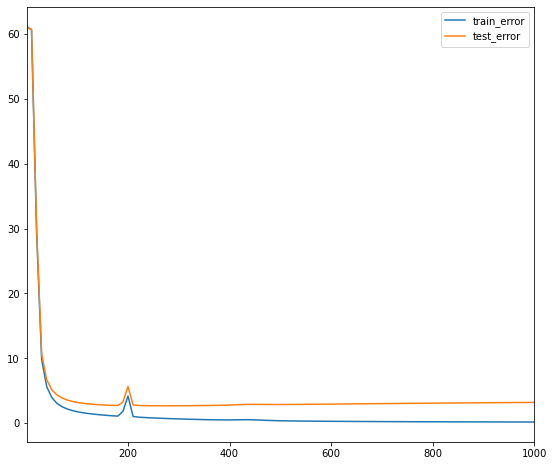

In [393]:
model = build_model(ratings, embedding_dim=30, init_stddev=.05)
model.train(num_iterations=1000, learning_rate=10)

In [394]:
movies

movie_id  anime_id                                 title  \
0            0     22199                        Akame ga Kill!   
1            1     32828                     Amaama to Inazuma   
2            2       269                                Bleach   
3            3     31043               Boku dake ga Inai Machi   
4            4     31964                 Boku no Hero Academia   
...        ...       ...                                   ...   
4477      4477     25519          Yuuki Yuuna wa Yuusha de Aru   
4478      4478      9737                        Appleseed XIII   
4479      4479      6032  Aquarion Movie: Ippatsu Gyakuten-hen   
4480      4480      2848           Kappa no Coo to Natsuyasumi   
4481      4481     31168   Pokemon XY: Odemashi Ko Majin Hoopa   

                                           main_picture  start_date  \
0     {'medium': 'https://api-cdn.myanimelist.net/im...  2014-07-07   
1     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-07-05   
2     {'medium': 'https://api-cdn.myanimelist.net/im...  2004-10-05   
3     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-01-08   
4     {'medium': 'https://api-cdn.myanimelist.net/im...  2016-04-03   
...                                                 ...         ...   
4477  {'medium': 'https://api-cdn.myanimelist.net/im...  2014-10-17   
4478  {'medium': 'https://api-cdn.myanimelist.net/im...  2011-06-03   
4479  {'medium': 'https://api-cdn.myanimelist.net/im...  2007-09-22   
4480  {'medium': 'https://api-cdn.myanimelist.net/im...  2007-07-28   
4481  {'medium': 'https://api-cdn.myanimelist.net/im...  2015-06-19   

        end_date                                             genres  Action  \
0     2014-12-15       [Action, Adventure, Drama, Fantasy, Shounen]       1   
1     2016-09-20           [Comedy, Gourmet, Seinen, Slice of Life]       0   
2     2012-03-27  [Action, Adventure, Comedy, Shounen, Super Pow...       1   
3     2016-03-25     [Mystery, Psychological, Seinen, Supernatural]       0   
4     2016-06-26     [Action, Comedy, School, Shounen, Super Power]       1   
...          ...                                                ...     ...   
4477  2014-12-26     [Drama, Fantasy, Psychological, Slice of Life]       0   
4478  2012-01-25          [Action, Mecha, Military, Police, Sci-Fi]       1   
4479  2007-09-22                            [Drama, Fantasy, Mecha]       0   
4480  2007-07-28                       [Adventure, Demons, Shounen]       0   
4481  2015-06-19                            [Action, Fantasy, Kids]       1   

      Adventure  Avant Garde  ...  Shounen  Slice of Life  Space  Sports  \
0             1            0  ...        1              0      0       0   
1             0            0  ...        0              1      0       0   
2             1            0  ...        1              0      0       0   
3             0            0  ...        0              0      0       0   
4             0            0  ...        1              0      0       0   
...         ...          ...  ...      ...            ...    ...     ...   
4477          0            0  ...        0              1      0       0   
4478          0            0  ...        0              0      0       0   
4479          0            0  ...        0              0      0       0   
4480          1            0  ...        1              0      0       0   
4481          0            0  ...        0              0      0       0   

      Super Power  Supernatural  Suspense  Vampire          genre  \
0               0             0         0        0         Action   
1               0             0         0        0        Gourmet   
2               1             1         0        0    Super Power   
3               0             1         0        0  Psychological   
4               1             0         0        0         Comedy   
...           ...           ...       ...      ...            ...   
4477           

In [395]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [396]:
# @title User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, user_id, measure=DOT, exclude_rated=False, k=6):
    if True:
        scores = compute_scores(model.embeddings["user_id"][user_id], model.embeddings["movie_id"], measure)
        score_key = measure + ' score'
        df = pd.DataFrame({
            score_key: list(scores),
            'movie_id': movies['movie_id'],
            'titles': movies['title'],
            'genres': movies['all_genres'],
        })
        if exclude_rated:
          # remove movies that are already rated
            rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
            df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
        display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
    # Search for movie ids that match the given substring.
    ids =  movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values
    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
            ", ".join(titles[1:])))
    movie_id = ids[0]
    scores = compute_scores(
        model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
        measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
        })
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [397]:
user_recommendations(model,446, measure=COSINE, k=5)

cosine score  movie_id                       titles  \
2429      0.948426      2429     Aishen Qiaokeli-ing...II   
1410      0.947927      1410                     Love Lab   
1562      0.947799      1562              Dai Mahou Touge   
3578      0.944599      3578               Sakura Nagashi   
3589      0.944273      3589  Senki Zesshou Symphogear XV   

                               genres  
2429      Comedy-Harem-Romance-School  
1410            Comedy-Romance-School  
1562              Comedy-Supernatural  
3578  Action-Drama-Mecha-Music-Sci-Fi  
3589              Action-Music-Sci-Fi

In [398]:
user_recommendations(model,446, measure=DOT, k=5)

dot score  movie_id                              titles  \
2885  10.167119      2885              Jujutsu Kaisen 0 Movie   
353    9.740410       353  Shingeki no Kyojin Season 3 Part 2   
3915   9.696173      3915                         Shion no Ou   
1018   9.689631      1018                       Steins;Gate 0   
87     9.668873        87                            Beastars   

                                                 genres  
2885                 Action-Demons-Shounen-Supernatural  
353   Action-Drama-Fantasy-Military-Mystery-Shounen-...  
3915                        Drama-Game-Mystery-Suspense  
1018                Drama-Psychological-Sci-Fi-Suspense  
87     Drama-Psychological-School-Shounen-Slice of Life

In [467]:
# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to c:\users\nathan van lingen\appdata\local\temp\pip-req-build-vy0x6n_g
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for altair: filename=altair-4.3.0.dev0-py3-none-any.whl size=822349 sha256=8fb41327e6fb8738481ebd4593b963a9fa2d67fe12e589dbb7660a1c87304a28
  Stored in directory: C:\Users\Nathan Van Lingen\AppData\Local\Temp\pip-ephem-wheel-cache-kdhytycm\wheels\75\f5\78\3d04c284a411de4eaafad1d652fca4319f15d29ad0bbf0b14e
Successfully built altair
Done installing Altair.


In [400]:
def movie_embedding_norm(models):
    """Visualizes the norm and number of ratings of the movie embeddings.
    Args:
    model: A MFModel object.
    """
    if not isinstance(models, list):
        models = [models]
    df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm'+str(i)
        df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
        nearest = alt.selection(
            type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
            empty='none')
        base = alt.Chart().mark_circle().encode(
            x='num_ratings',
            y=norm_key,
            color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
        ).properties(
            selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
            x='num_ratings', y=norm_key,
            text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
        return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
    ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
    """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model.embeddings["movie_id"])
    movies.loc[:,'x'] = V_proj[:, 0]
    movies.loc[:,'y'] = V_proj[:, 1]
    return visualize_movie_embeddings(movies, 'x', 'y')

In [498]:
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [402]:
movies_ratings = movies.copy()
movies_ratings = pd.concat([movies_ratings,ratings.groupby('movie_id').mean()['score'], \
           ratings.groupby('movie_id').count()['user_id']], axis=1)\
            .rename({'score':'rating mean', 'user_id':'rating count'},axis=1)

In [406]:
movie_embedding_norm(model)

alt.HConcatChart(...)

(447, 4482)
Tensor("mean_squared_error_30/value:0", shape=(), dtype=float32)
 iteration 1000: train_error=0.174857, test_error=3.444036Nearest neighbors of : Sword Art Online II.
[Found more than one matching movie. Other candidates: Sword Art Online: Alicization, Sword Art Online, Sword Art Online Movie: Ordinal Scale, Sword Art Online Alternative: Gun Gale Online, Sword Art Online: Extra Edition, Sword Art Online: Alicization - War of Underworld, Sword Art Online: Alicization - War of Underworld 2nd Season, Sword Art Online: Progressive Movie - Hoshi Naki Yoru no Aria, Sword Art Online II: Debriefing, Sword Art Online II: Sword Art Offline II, Sword Art Online: Alicization - War of Underworld Recap, Sword Art Online: Alicization - Recollection, Sword Art Online: Alicization - War of Underworld Reflection, Sword Art Online: Sword Art Offline - Extra Edition, Sword Art Online Movie: Ordinal Scale - Sword Art Offline, Sword Art Online Alternative: Gun Gale Online - Refrain, Sword Art On

dot score                                             titles  \
357    9.809845                                Sword Art Online II   
564    7.213147                                   Sword Art Online   
743    6.105422      Sword Art Online Alternative: Gun Gale Online   
693    5.371309                                        Tenki no Ko   
1193   5.317518  Sword Art Online: Alicization - War of Underworld   
816    5.226748        Hige wo Soru. Soshite Joshikousei wo Hirou.   

                                     genres  
357   Action-Adventure-Fantasy-Game-Romance  
564   Action-Adventure-Fantasy-Game-Romance  
743     Action-Fantasy-Game-Military-Sci-Fi  
693     Drama-Fantasy-Romance-Slice of Life  
1193  Action-Adventure-Fantasy-Game-Romance  
816                           Drama-Romance

Nearest neighbors of : Sword Art Online II.
[Found more than one matching movie. Other candidates: Sword Art Online: Alicization, Sword Art Online, Sword Art Online Movie: Ordinal Scale, Sword Art Online Alternative: Gun Gale Online, Sword Art Online: Extra Edition, Sword Art Online: Alicization - War of Underworld, Sword Art Online: Alicization - War of Underworld 2nd Season, Sword Art Online: Progressive Movie - Hoshi Naki Yoru no Aria, Sword Art Online II: Debriefing, Sword Art Online II: Sword Art Offline II, Sword Art Online: Alicization - War of Underworld Recap, Sword Art Online: Alicization - Recollection, Sword Art Online: Alicization - War of Underworld Reflection, Sword Art Online: Sword Art Offline - Extra Edition, Sword Art Online Movie: Ordinal Scale - Sword Art Offline, Sword Art Online Alternative: Gun Gale Online - Refrain, Sword Art Online Fatal Bullet: The Third Episode, Sword Art Online Fatal Bullet: The Third Episode - Pilot-ban, Sword Art Online: Sword Art Offline

cosine score                                           titles  \
357       1.000000                              Sword Art Online II   
564       0.758590                                 Sword Art Online   
1396      0.701174                                       Fairy Gone   
2225      0.680242                               Beyblade Burst God   
2034      0.676753               UQ Holder!: Mahou Sensei Negima! 2   
932       0.676707  Shinka no Mi: Shiranai Uchi ni Kachigumi Jinsei   

                                     genres  
357   Action-Adventure-Fantasy-Game-Romance  
564   Action-Adventure-Fantasy-Game-Romance  
1396     Action-Demons-Fantasy-Supernatural  
2225    Action-Adventure-Kids-Sci-Fi-Sports  
2034          Action-Fantasy-Sci-Fi-Shounen  
932               Adventure-Fantasy-Romance

alt.HConcatChart(...)

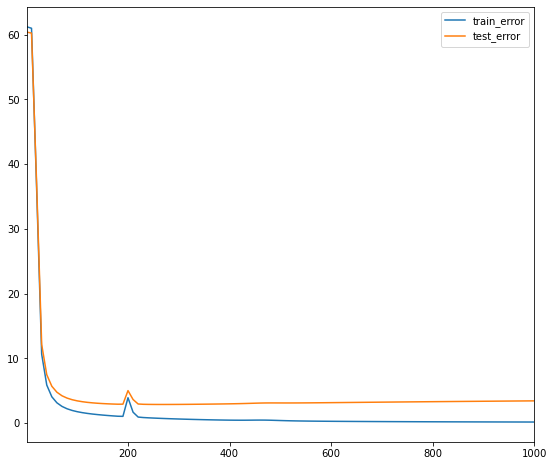

In [438]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Sword Art Online", DOT)
movie_neighbors(model_lowinit, "Sword Art Online", COSINE)
movie_embedding_norm([model, model_lowinit])

In [461]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4482 samples in 0.000s...
[t-SNE] Computed neighbors for 4482 samples in 0.491s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4482
[t-SNE] Computed conditional probabilities for sample 2000 / 4482
[t-SNE] Computed conditional probabilities for sample 3000 / 4482
[t-SNE] Computed conditional probabilities for sample 4000 / 4482
[t-SNE] Computed conditional probabilities for sample 4482 / 4482
[t-SNE] Mean sigma: 0.093968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.785477
[t-SNE] KL divergence after 400 iterations: 2.357888


alt.HConcatChart(...)

In [496]:
movies_ratings
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

 iteration 2000: train_error_observed=1.261761, test_error_observed=14.242356, observed_loss=1.261761, regularization_loss=1.866278, gravity_loss=3.773648

[{'train_error_observed': 1.2617612, 'test_error_observed': 14.242356},
 {'observed_loss': 1.2617612,
  'regularization_loss': 1.8662776,
  'gravity_loss': 3.773648}]

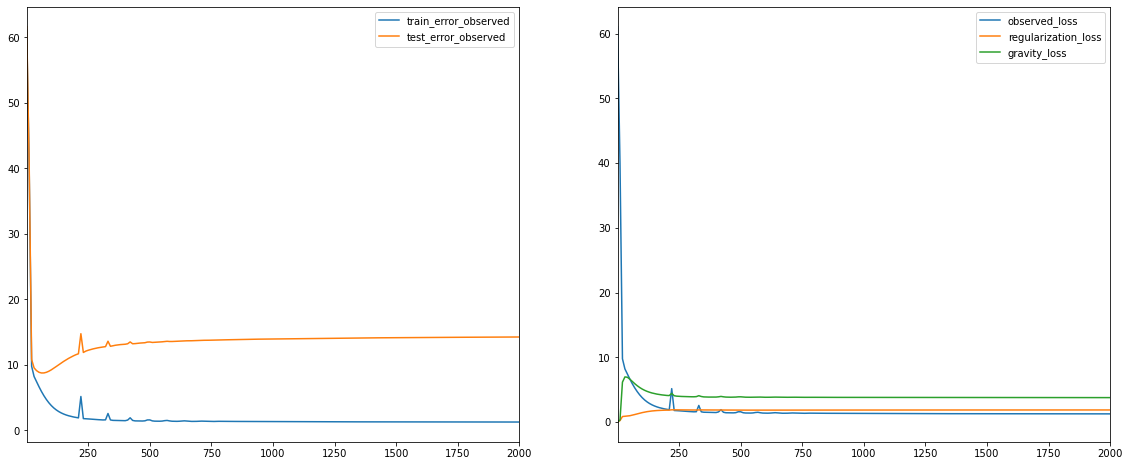

In [265]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [358]:
user_recommendations(reg_model,446, DOT, exclude_rated=True, k=20)

dot score  movie_id                                             titles  \
1018   9.603985      1018                                      Steins;Gate 0   
42     9.244615        42                                     Kimi no Na wa.   
342    9.169962       342  Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...   
372    8.964956       372                                          Toradora!   
25     8.557627        25                                Fullmetal Alchemist   
543    8.525537       543                                          One Piece   
341    8.463552       341   Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season   
335    8.082704       335                              Ookami to Koushinryou   
65     7.952281        65                      Ansatsu Kyoushitsu 2nd Season   
522    7.948836       522                                       Black Clover   
123    7.757161       123                    Code Geass: Hangyaku no Lelouch   
44     7.715192        44                                     Koe no Katachi   
1184   7.711311      1184                           Ookami to Koushinryou II   
3      7.602171         3                            Boku dake ga Inai Machi   
287    7.460786       287  Itai no wa Iya nano de Bougyoryoku ni Kyokufur...   
1116   7.295019      1116                                Satsuriku no Tenshi   
757    7.285016       757                                Hataraku Maou-sama!   
565    7.204403       565                         Tengen Toppa Gurren Lagann   
124    7.174842       124                 Code Geass: Hangyaku no Lelouch R2   
567    7.031104       567                                   Tonari no Totoro   

                                                 genres  
1018                Drama-Psychological-Sci-Fi-Suspense  
42                    Drama-Romance-School-Supernatural  
342                Drama-Fantasy-Psychological-Suspense  
372                 Comedy-Romance-School-Slice of Life  
25    Action-Adventure-Comedy-Drama-Fantasy-Military...  
543   Action-Adventure-Comedy-Drama-Fantasy-Shounen-...  
341                Drama-Fantasy-Psychological-Suspense  
335                Adventure-Fantasy-Historical-Romance  
65                         Action-Comedy-School-Shounen  
522                       Action-Comedy-Fantasy-Shounen  
123   Action-Drama-Mecha-Military-School-Sci-Fi-Supe...  
44                                 Drama-School-Shounen  
1184               Adventure-Fantasy-Historical-Romance  
3             Mystery-Psychological-Seinen-Supernatural  
287         Action-Adventure-Comedy-Fantasy-Game-Sci-Fi  
1116            Adventure-Horror-Psychological-Suspense  
757          Comedy-Demons-Fantasy-Romance-Supernatural  
565                Action-Adventure-Comedy-Mecha-Sci-Fi  
124      Action-Drama-Mecha-Military-Sci-Fi-Super Power  
567                              Adventure-Supernatural

In [362]:
movie_neighbors(reg_model, "No Game No Life", DOT)
movie_neighbors(reg_model, "No Game No Life", COSINE)

Nearest neighbors of : No Game No Life.
[Found more than one matching movie. Other candidates: No Game No Life: Zero, No Game No Life Specials, No Game No Life: Zero - Manner Movie]


dot score                                    titles  \
241  31.435179                          Kimetsu no Yaiba   
332  31.212061                           No Game No Life   
42   30.447767                            Kimi no Na wa.   
306  30.189938  Kimetsu no Yaiba Movie: Mugen Ressha-hen   
8    29.597980                                Death Note   
40   29.085178                    Hunter x Hunter (2011)   

                                                genres  
241      Action-Demons-Historical-Shounen-Supernatural  
332   Adventure-Comedy-Ecchi-Fantasy-Game-Supernatural  
42                   Drama-Romance-School-Supernatural  
306             Demons-Historical-Shounen-Supernatural  
8    Mystery-Police-Psychological-Shounen-Supernatu...  
40        Action-Adventure-Fantasy-Shounen-Super Power

Nearest neighbors of : No Game No Life.
[Found more than one matching movie. Other candidates: No Game No Life: Zero, No Game No Life Specials, No Game No Life: Zero - Manner Movie]


cosine score                         titles  \
332      1.000000                No Game No Life   
64       0.881004             Ansatsu Kyoushitsu   
3        0.857120        Boku dake ga Inai Machi   
241      0.843773               Kimetsu no Yaiba   
65       0.843241  Ansatsu Kyoushitsu 2nd Season   
333      0.834586                  One Punch Man   

                                                genres  
332   Adventure-Comedy-Ecchi-Fantasy-Game-Supernatural  
64                        Action-Comedy-School-Shounen  
3            Mystery-Psychological-Seinen-Supernatural  
241      Action-Demons-Historical-Shounen-Supernatural  
65                        Action-Comedy-School-Shounen  
333  Action-Comedy-Parody-Sci-Fi-Super Power-Supern...

In [363]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [409]:
movie_embedding_norm(reg_model)

alt.HConcatChart(...)